__Autoencoder tries to reconstruct the input. So, both the input and label are the same.__

In [23]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

%matplotlib inline


## Data Preprocessing

In [6]:
def map_image(image, label):
  '''
  Normalizes the image. Returns image as input and label.
  '''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))
  return image, image


In [7]:
# Load the train and test sets from TFDS
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()


In [8]:
print("Train dataset spec:", train_dataset.element_spec)
print("Test dataset spec:", test_dataset.element_spec)


Train dataset spec: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))
Test dataset spec: (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))


Image Shape:  (28, 28, 1)


2025-04-25 10:59:07.214706: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


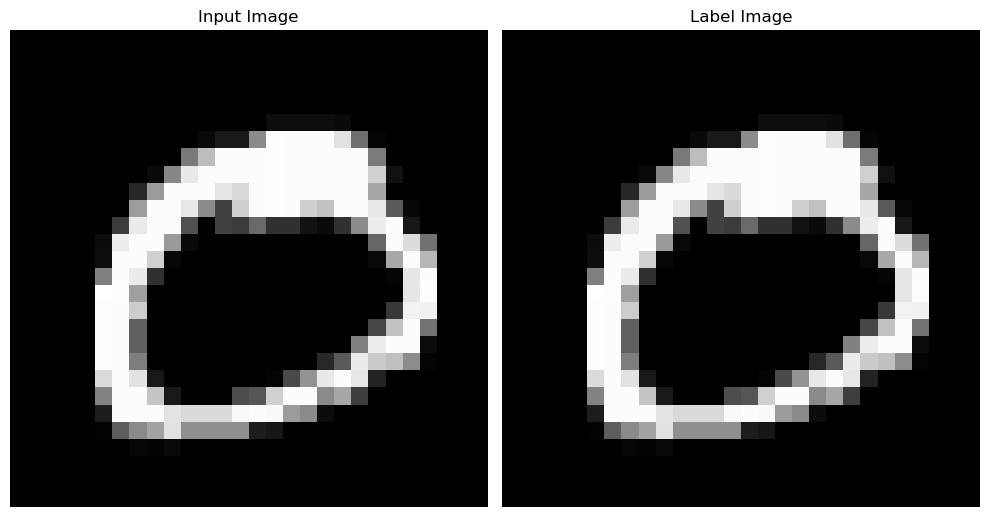

In [9]:
for image, label in train_dataset.take(1):
    image = image[0].numpy()
    label = label[0].numpy()
    break

print("Image Shape: ", image.shape)
# Plot the image and label
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot input image
axes[0].imshow(image.squeeze(), cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

# Plot label image (same as input for autoencoders)
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Label Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()


## Build Autoencoder Model

In [6]:
# Model 1
image = image.flatten()
input_shape = image.shape
encoder = keras.models.Sequential([
    keras.Input(shape=input_shape),
    keras.layers.Dense(128)
    ])

decoder = keras.models.Sequential([
    keras.Input(shape=(128, )),
    keras.layers.Dense(input_shape[0])
    ])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,616 (787.56 KB)

 Trainable params: 201,616 (787.56 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Model 2
autoencoder = keras.models.Sequential([
    # Input Layer
    keras.Input(shape=input_shape),

    # Encoder
    keras.layers.Dense(128),

    # Decoder
    keras.layers.Dense(input_shape[0])
])
autoencoder.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,616 (787.56 KB)

 Trainable params: 201,616 (787.56 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.01))


In [9]:
# Add batch dimension
image = tf.expand_dims(image, axis=0) # shape: (1, 784)

history = autoencoder.fit(image, image, epochs=200)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0767
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0765
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0764
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0762
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0760
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0758
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0757
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0755
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0753
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0752
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0750
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0748
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0747
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0745
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0743
Epoch 16/200
1/1 ━

In [10]:
# encode the data
encodings = encoder.predict(image)

# decode the encoder output
decodings = decoder.predict(encodings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


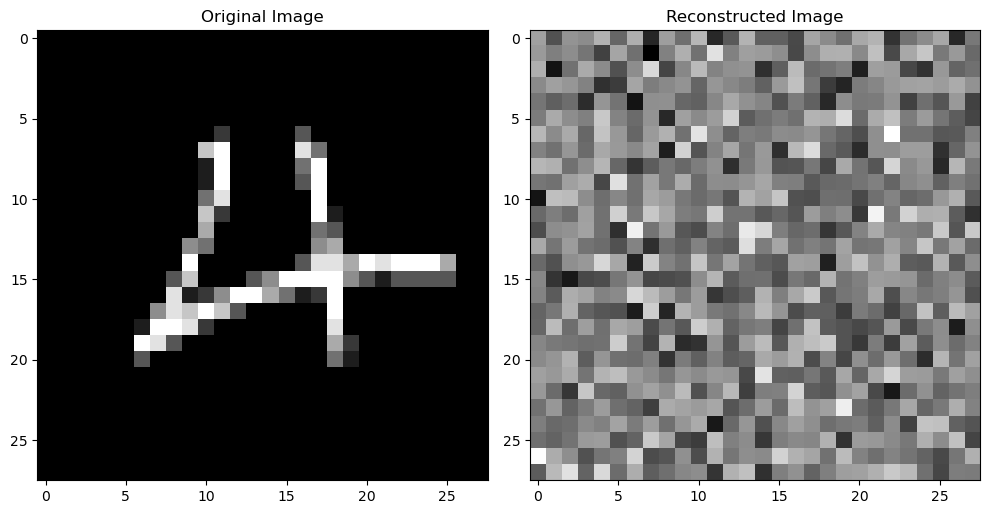

In [11]:
# Plot the input and output images
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Original input
axes[0].imshow(image.numpy().reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")

# Reconstructed image
axes[1].imshow(decodings.squeeze().reshape(28, 28), cmap='gray')
axes[1].set_title("Reconstructed Image")

plt.tight_layout()
plt.show()


## Build Deep Autoencoder Model

In [12]:
# Input Layer
inputs =  tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)

# Encoder
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
encoder = tf.keras.layers.Dense(units=32, activation='relu')(x)

# Decoder
x = tf.keras.layers.Dense(units=64, activation='relu')(encoder)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
decoder = tf.keras.layers.Dense(units=784, activation='sigmoid')(x)

# Output reshaped to image
outputs = tf.keras.layers.Reshape((28, 28, 1))(decoder)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
train_steps = 60000 // BATCH_SIZE

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)


Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2845
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1366
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1218
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1144
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1091
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1055
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1024
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1000
Epoch 9/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0980
Epoch 10/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0966
Epoch 11/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0954
Epoch 12/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0944
Epoch 13/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0936
Epoch 14/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0927
Epoch 15/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


2025-04-23 20:37:21.271416: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


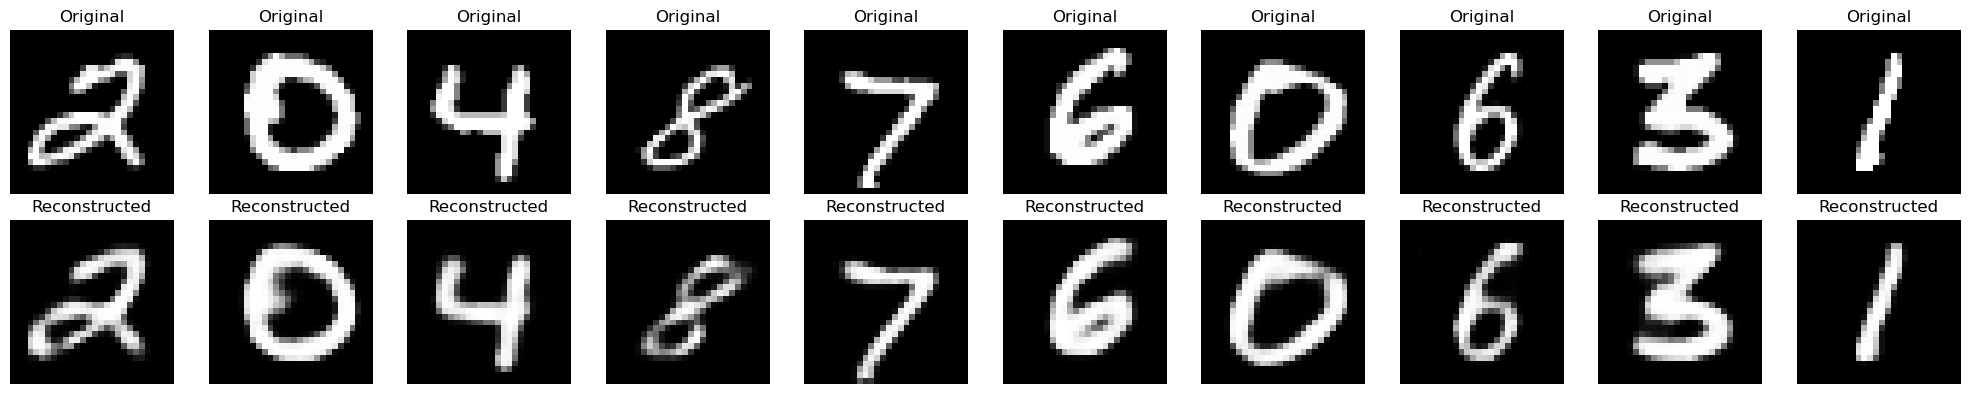

In [14]:
# Take a single batch from test_dataset
for batch in test_dataset.take(1):
    test_images, _ = batch  # Ignoring labels since it's autoencoder
    break

# Predict using the autoencoder model
reconstructed_images = model.predict(test_images)

# Plot original vs reconstructed
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(test_images[i]), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(reconstructed_images[i]), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Build Convolutional Autoencoder Model

In [15]:
# Input Layer
inputs = tf.keras.Input((28, 28, 1))

# Encoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(encoded)
x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# Crop to 28x28 if needed
decoded = tf.keras.layers.Cropping2D(((2, 2), (2, 2)))(decoded)  # 28x28x1

# Model
model = tf.keras.Model(inputs=inputs, outputs=decoded)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

<p style="color:orange"><strong>You only need to set steps_per_epoch when:</strong></p>

<ul>
  <li>You’re using a <code>tf.data.Dataset</code> that is <em>infinitely repeating</em> (e.g. <code>train_dataset.repeat()</code>)</li>
  <li>Or when your dataset is not explicitly batched to total steps, so Keras can't auto-infer the steps</li>
</ul>


In [16]:
train_steps = 60000 // BATCH_SIZE

model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)


Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.2427
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0827
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0760
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0731
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0715
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0704
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0695
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0688
Epoch 9/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0683
Epoch 10/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0678
Epoch 11/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0674
Epoch 12/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0670
Epoch 13/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0667
Epoch 14/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0665
Epoch 15/50
468/468 ━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


2025-04-23 20:47:06.996545: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


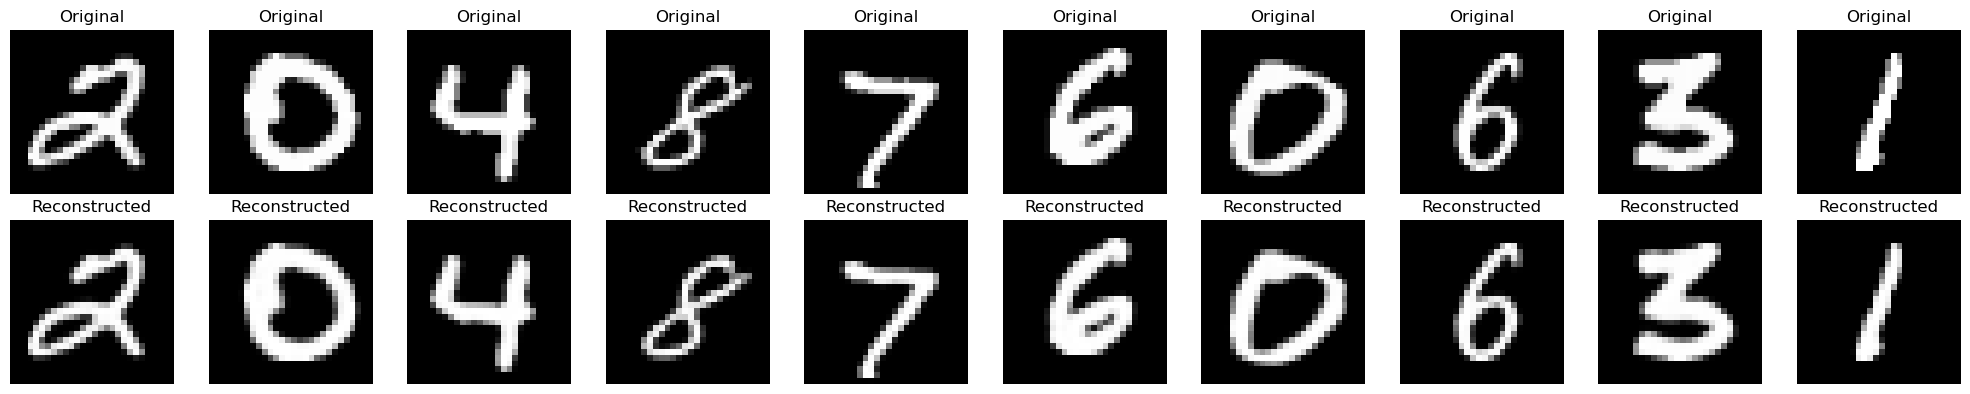

In [17]:
# Take a single batch from test_dataset
for batch in test_dataset.take(1):
    test_images, _ = batch  # Ignoring labels since it's autoencoder
    break

# Predict using the autoencoder model
reconstructed_images = model.predict(test_images)

# Plot original vs reconstructed
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(test_images[i]), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(reconstructed_images[i]), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Variational Autoencoder Model

In [56]:
def map_image(image, label):
    '''
    returns a normalized and reshaped tensor from a given image
    '''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = tf.reshape(image, shape=(28, 28, 1,))
    
    return image


In [57]:
# Load the train and test sets from TFDS
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024
LATENT_DIM = 2

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()


In [67]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    # unpack the output of the encoder
    mu, sigma = inputs

    # get the size and dimensions of the batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    #print("batch: ", batch)
    #print("dim: ", dim)

    # generate a random tensor
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    #print("epsilon: ", epsilon)

    # combine the inputs and noise
    return mu + tf.exp(0.5 * sigma) * epsilon


In [68]:
class KLDLayer(tf.keras.layers.Layer):
  def call(self, inputs):
    """Computes the KLD loss and adds it to the model

    Args:
      inputs -- tensor containing (mu, sigma)

    Returns:
      kl_loss -- computed Kullback–Leibler Divergence loss
    """

    # unpack the inputs
    mu, sigma = inputs

    # compute the loss
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    # store the result
    self.add_loss(kl_loss)

    return kl_loss


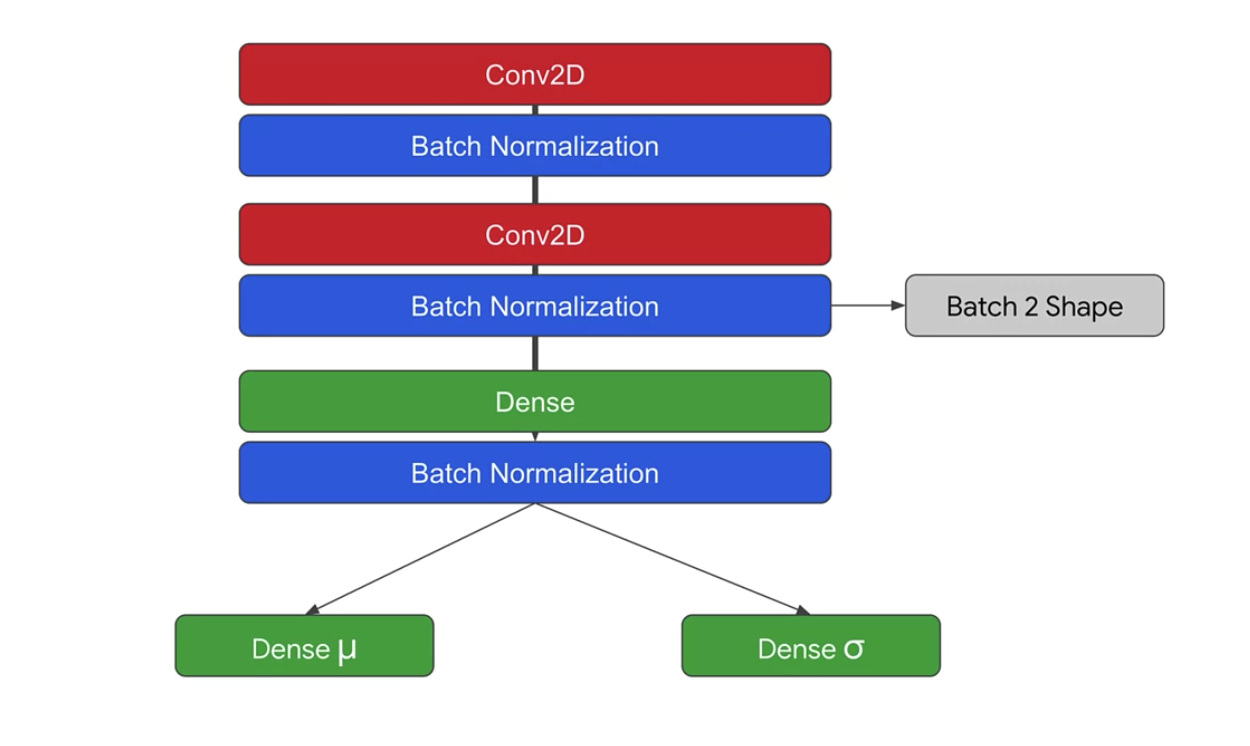

In [69]:
# Display the image
display(Image(filename='VAE_Encoder_Architecture.png', width=500, height=350))


In [70]:
def encoder_model(input_shape, latent_dim):
    # Input Layer
    inputs = keras.Input(shape=input_shape)

    # Encoder Layers
    x = keras.layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same', name='encode_conv1')(inputs)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same', name='encode_conv2')(x)
    batch_2 = keras.layers.BatchNormalization()(x)

    x = keras.layers.Flatten(name="encode_flatten")(batch_2)
    x = keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
    x = keras.layers.BatchNormalization()(x)

    mu = keras.layers.Dense(latent_dim, name="latent_mu")(x)
    sigma = keras.layers.Dense(latent_dim, name="latent_sigma")(x)
    conv_shape = batch_2.shape

    # feed mu and sigma to the Sampling layer
    z = Sampling()((mu, sigma))

    # feed mu and sigma to the KLD layer
    kl_loss = KLDLayer()((mu, sigma))
    
    # build the whole encoder model
    model = keras.Model(inputs=inputs, outputs=[z, kl_loss])
    
    return model, conv_shape


In [71]:
def decoder_model(latent_dim, conv_shape):
    # Input Layer
    inputs = tf.keras.Input(shape=(latent_dim,))
    
    # Decoder Layers
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    #units = tf.reduce_prod(conv_shape[1:])
    x = keras.layers.Dense(units, activation='relu', name='decoder_dense1')(inputs)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name='decoder_reshape')(x)

    x = keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu', name='decoder_convt1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu', name='decoder_convt2')(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Conv2DTranspose(1, (3, 3), strides=1, padding='same', activation='sigmoid', name='decoder_convt3')(x)
    
    # Build the Decoder model
    model = keras.Model(inputs, outputs)
    
    return model


In [72]:
def vae_model(encoder, decoder, input_shape):
    # Input Layer
    inputs = keras.Input(shape=input_shape)

    # get z from the encoder output
    z, _ = encoder(inputs)

    # get reconstructed output from the decoder
    reconstructed = decoder(z)

    # Get VAE Model
    vae = keras.Model(inputs=inputs, outputs=reconstructed)

    return vae

def get_models(input_shape, latent_dim):
    """
    Returns the encoder, decoder, and vae models
    """
    # Get Encoder Model
    encoder, conv_shape = encoder_model(input_shape, latent_dim)
    # Get Decoder Model
    decoder = decoder_model(latent_dim, conv_shape)
    # Get VAE Model
    vae = vae_model(encoder, decoder, input_shape)
    return encoder, decoder, vae

# Usage
encoder, decoder, vae = get_models((28, 28, 1), LATENT_DIM)


In [73]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()


In [74]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


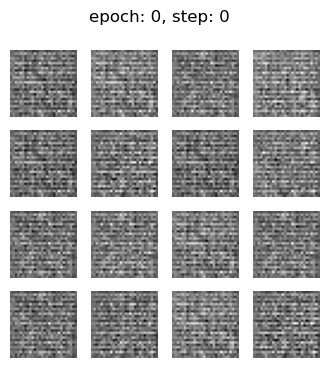

In [75]:
# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 15

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)


In [77]:
from IPython.display import clear_output


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


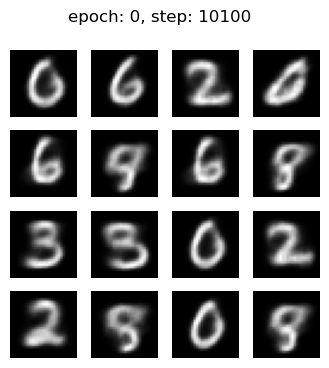

Epoch: 0 step: 10100 mean loss = 152.2023


In [ ]:
# Training loop.
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784

      # add KLD regularization loss
      loss += sum(vae.losses)

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))
